In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!pip install catboost

In [0]:
import pandas as pd
import datetime
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score
from joblib import dump, load
from sklearn.naive_bayes import GaussianNB
from google.colab import drive
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import seaborn as sns
# from copy import copy
from sklearn.ensemble import RandomForestClassifier
# from catboost import CatBoostClassifier, Pool, cv
from sklearn.metrics import accuracy_score
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from sklearn.feature_selection import RFECV
import lightgbm as lgb
from sklearn.svm import SVC

In [0]:
def process_train(filepath):
    '''
    Reads file from filepath, returns a dataframe with required columns
    :param filepath: string path
    :param column_list: list of Dataframe column
    :return: Dataframe
    '''
    return pd.read_csv(filepath)

#Splitting train and test
def normalize_dataset(features_df):
    """
    Normalize the dataset
    :param features_dataframe:
    :return: normalized_features_array
    """ 
    #Using minmaxscaler from sklearn to normalize dataset
    min_max_scaler = MinMaxScaler()
    return min_max_scaler.fit_transform(features_df)

#Splitting train and test
def split_dataset(features_np_array, target_np_array, test_percentage, random_state):
    """
    Split the dataset with train_percentage
    :param dataset:
    :param test_percentage:
    :param feature_array:
    :param target_array:
    :return: train_x, test_x, train_y, test_y
    """ 
    #Split dataset into train and test dataset
    train_x, test_x, train_y, test_y = train_test_split(features_np_array, target_np_array, test_size = test_percentage, random_state = random_state)
    return train_x, test_x, train_y, test_y

def generate_csv(df,csv_name):
    '''
    Converting pred_labels to dataframe
    :param csv_name:
    :return: submission_csv
    '''
    return df.to_csv(csv_name, index = False)


In [0]:
train = process_train('/content/gdrive/My Drive/LTFS/train.csv')

In [0]:
# Preprocessing 
# Removing rows with empty records for column Employment type
train['Employment.Type'] = train['Employment.Type'].fillna('0')
# train = train.loc[~(train['Employment.Type'] == '0'), :]


# Converting State ID column to a column to frequency count
d = {val:count for val,count in zip(train['State_ID'].value_counts().index, train['State_ID'].value_counts().values)}
train['State_ID'] = train['State_ID'].apply(lambda x : round(d[x]/len(train), 2))

# Converting State ID column to a column to frequency count
d = {val:count for val,count in zip(train['Employee_code_ID'].value_counts().index, train['Employee_code_ID'].value_counts().values)}
train['Employee_code_ID'] = train['Employee_code_ID'].apply(lambda x : round(d[x]/len(train), 4))

# Converting State ID column to a column to frequency count
d = {val:count for val,count in zip(train['branch_id'].value_counts().index, train['branch_id'].value_counts().values)}
train['branch_id'] = train['branch_id'].apply(lambda x : round(d[x]/len(train), 2))


# Converting State ID column to a column to frequency count
d = {val:count for val,count in zip(train['Current_pincode_ID'].value_counts().index, train['Current_pincode_ID'].value_counts().values)}
train['Current_pincode_ID'] = train['Current_pincode_ID'].apply(lambda x : round(d[x]/len(train), 4))

# Converting supplier_id column to a column to frequency count
d = {val:count for val,count in zip(train['supplier_id'].value_counts().index, train['supplier_id'].value_counts().values)}
train['supplier_id'] = train['supplier_id'].apply(lambda x : round(d[x]/len(train), 4))

# Converting manufacturer_id column to a column to frequency count
d = {val:count for val,count in zip(train['manufacturer_id'].value_counts().index, train['manufacturer_id'].value_counts().values)}
train['manufacturer_id'] = train['manufacturer_id'].apply(lambda x : round(d[x]/len(train), 4))

# Adding all the flags
train['flag_sum'] = train.iloc[:, 13:19].sum(axis = 1)


# Converting DisbursalDate column to number of days
train['DisbursalDate'] = train['DisbursalDate'].apply(lambda x :  datetime.datetime.now().day - datetime.datetime.strptime(x, '%d-%m-%y').day)
train['DisbursalDate'] = train['DisbursalDate'].apply(lambda x : abs(x))


# Converting date of birth column to age
train['Date.of.Birth'] = train['Date.of.Birth'].apply(lambda x :  datetime.datetime.now().year - datetime.datetime.strptime(x, '%d-%m-%y').year)
train['Date.of.Birth'] = train['Date.of.Birth'].apply(lambda x : abs(x))
train['Employment.Type'] = train['Employment.Type'].map({'Salaried' : 0, 'Self employed' : 1, '0' : 0})


# Imputing a CNS score of 598 (medium risk) for all the customers with 0(No score available) or 17(Not enough data to compute score) CNS scores
train.loc[(train['PERFORM_CNS.SCORE'] == 0) | (train['PERFORM_CNS.SCORE'] == 17), 'PERFORM_CNS.SCORE'] = 598
train.loc[:, 'PERFORM_CNS.SCORE'] = train.loc[:, 'PERFORM_CNS.SCORE'].apply(lambda x : round(1/x, 4))



In [0]:
# Trying feature selection 
# Using recursive feature selection method with logreg
rfecv = RFECV(estimator=logreg, step=1, cv=StratifiedKFold(2),
              scoring='roc_auc')
to_exclude = ['UniqueID', 'loan_default','CREDIT.HISTORY.LENGTH', 'PERFORM_CNS.SCORE.DESCRIPTION', 'AVERAGE.ACCT.AGE']
rfecv.fit(train.loc[:, train.columns.difference(to_exclude)], train['loan_default'])

print("Optimal number of features : %d" % rfecv.n_features_)



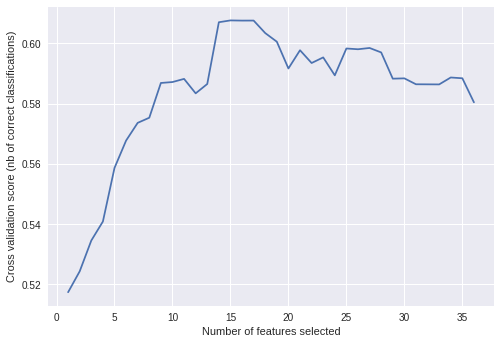

In [28]:
# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [0]:
imp_cols = []
for i in range(len(rfecv.ranking_)):
    if rfecv.ranking_[i] == 1:
        imp_cols.append(train.columns.difference(to_exclude)[i])    

In [23]:
train.columns

Index(['UniqueID', 'disbursed_amount', 'asset_cost', 'ltv', 'branch_id',
       'supplier_id', 'manufacturer_id', 'Current_pincode_ID', 'Date.of.Birth',
       'Employment.Type', 'DisbursalDate', 'State_ID', 'Employee_code_ID',
       'MobileNo_Avl_Flag', 'Aadhar_flag', 'PAN_flag', 'VoterID_flag',
       'Driving_flag', 'Passport_flag', 'PERFORM_CNS.SCORE',
       'PERFORM_CNS.SCORE.DESCRIPTION', 'PRI.NO.OF.ACCTS', 'PRI.ACTIVE.ACCTS',
       'PRI.OVERDUE.ACCTS', 'PRI.CURRENT.BALANCE', 'PRI.SANCTIONED.AMOUNT',
       'PRI.DISBURSED.AMOUNT', 'SEC.NO.OF.ACCTS', 'SEC.ACTIVE.ACCTS',
       'SEC.OVERDUE.ACCTS', 'SEC.CURRENT.BALANCE', 'SEC.SANCTIONED.AMOUNT',
       'SEC.DISBURSED.AMOUNT', 'PRIMARY.INSTAL.AMT', 'SEC.INSTAL.AMT',
       'NEW.ACCTS.IN.LAST.SIX.MONTHS', 'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS',
       'AVERAGE.ACCT.AGE', 'CREDIT.HISTORY.LENGTH', 'NO.OF_INQUIRIES',
       'loan_default', 'flag_sum'],
      dtype='object')

In [0]:
imp_cols = [
 'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS',
 'DisbursalDate',
 'Employment.Type',
 'NEW.ACCTS.IN.LAST.SIX.MONTHS',
 'NO.OF_INQUIRIES',
 'PRI.ACTIVE.ACCTS',
 'PRI.OVERDUE.ACCTS',
 'SEC.NO.OF.ACCTS',
 'State_ID',
 'ltv',
 'Date.of.Birth',
 'PERFORM_CNS.SCORE',
 'PRI.NO.OF.ACCTS',
 'flag_sum',
 'Employee_code_ID',
 'branch_id',
 'Current_pincode_ID',
 'supplier_id',
 'manufacturer_id']

In [0]:
train_features = train[imp_cols]

In [0]:
train_features_array = normalize_dataset(train_features)

In [12]:
train_features_array.shape

(233154, 19)

In [0]:
train_labels = train['loan_default']

In [0]:
train_X, val_X, train_Y, val_Y = split_dataset(train_features_array, train_labels, 0.3, 42)

In [0]:
# Fitting models
logreg = LogisticRegression(random_state = 42, C = 1, class_weight = 'balanced')
# logreg.fit(train_X,train_Y)

In [0]:
# Evaluating performance 
logreg_pred_val = logreg.predict(val_X)

In [54]:
print(classification_report(val_Y, logreg_pred_val))
print(roc_auc_score(val_Y, logreg_pred_val))

              precision    recall  f1-score   support

           0       0.84      0.55      0.66     54756
           1       0.27      0.62      0.38     15191

   micro avg       0.56      0.56      0.56     69947
   macro avg       0.56      0.58      0.52     69947
weighted avg       0.71      0.56      0.60     69947

0.5818441215171567


In [57]:
logreg_pred_test = pd.DataFrame(logreg_pred_val)
test_uid_df = pd.DataFrame(test['UniqueID'], columns = ['UniqueID'])
logreg_pred_test = test_uid_df.join(logreg_pred_test, how = 'inner')
logreg_pred_test.columns = ['UniqueID', 'loan_default']
generate_csv(logreg_pred_test, 'logreg_pred.csv')
vc_pred_test['loan_default'].value_counts()

0    93152
1    19240
Name: loan_default, dtype: int64

In [0]:
nb = GaussianNB()
# nb.fit(train_X,train_Y)

In [55]:
nb_pred_val = nb.predict(val_X)
print(classification_report(val_Y, nb_pred_val))
print(roc_auc_score(val_Y, nb_pred_val))

              precision    recall  f1-score   support

           0       0.79      0.95      0.86     54756
           1       0.32      0.09      0.14     15191

   micro avg       0.76      0.76      0.76     69947
   macro avg       0.55      0.52      0.50     69947
weighted avg       0.69      0.76      0.70     69947

0.5176902438989555


In [0]:
xgb_params={'colsample_bylevel': 1, 'colsample_bytree': 1, 'max_depth': 3, 
            'min_child_weight': 50, 'reg_alpha': 0.5, 'reg_lambda': 1, 
            'scale_pos_weight': 5, 'subsample': 0.5, 'learning_rate':0.3, 'gamma' : 5}

xgb_model = XGBClassifier(random_state=51,n_jobs=-1,**xgb_params)


In [42]:
xgb_model.fit(train_X,train_Y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=50, missing=None, n_estimators=100,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=51, reg_alpha=0.5, reg_lambda=1, scale_pos_weight=5,
       seed=None, silent=True, subsample=0.5)

In [43]:
xgb_pred_val = xgb_model.predict(val_X)
print(classification_report(val_Y, xgb_pred_val))


              precision    recall  f1-score   support

           0       0.88      0.33      0.48     54756
           1       0.26      0.84      0.40     15191

   micro avg       0.44      0.44      0.44     69947
   macro avg       0.57      0.59      0.44     69947
weighted avg       0.75      0.44      0.46     69947



In [0]:
# Using ensemble model 
vc_model = VotingClassifier([('nb',nb),('logreg',logreg), ('xgb', xgb_model)],voting='soft')
# vc_model.fit(train_X, train_Y)

In [46]:
vc_pred_val = vc_model.predict(val_X)
print(roc_auc_score(val_Y, vc_pred_val))

0.561182785690296


In [48]:
dump(vc_model, 'vc_model.joblib')

['vc_model.joblib']

In [0]:
test = process_train('/content/gdrive/My Drive/LTFS/test.csv')

In [0]:
# Preprocessing 
# Removing rows with empty records for column Employment type
test['Employment.Type'] = test['Employment.Type'].fillna('0')
# test = test.loc[~(test['Employment.Type'] == '0'), :]


# Converting State ID column to a column to frequency count
d = {val:count for val,count in zip(test['State_ID'].value_counts().index, test['State_ID'].value_counts().values)}
test['State_ID'] = test['State_ID'].apply(lambda x : round(d[x]/len(test), 2))

# Converting State ID column to a column to frequency count
d = {val:count for val,count in zip(test['Employee_code_ID'].value_counts().index, test['Employee_code_ID'].value_counts().values)}
test['Employee_code_ID'] = test['Employee_code_ID'].apply(lambda x : round(d[x]/len(test), 4))

# Converting State ID column to a column to frequency count
d = {val:count for val,count in zip(test['branch_id'].value_counts().index, test['branch_id'].value_counts().values)}
test['branch_id'] = test['branch_id'].apply(lambda x : round(d[x]/len(test), 2))


# Converting State ID column to a column to frequency count
d = {val:count for val,count in zip(test['Current_pincode_ID'].value_counts().index, test['Current_pincode_ID'].value_counts().values)}
test['Current_pincode_ID'] = test['Current_pincode_ID'].apply(lambda x : round(d[x]/len(test), 4))

# Converting supplier_id column to a column to frequency count
d = {val:count for val,count in zip(test['supplier_id'].value_counts().index, test['supplier_id'].value_counts().values)}
test['supplier_id'] = test['supplier_id'].apply(lambda x : round(d[x]/len(test), 4))

# Converting manufacturer_id column to a column to frequency count
d = {val:count for val,count in zip(test['manufacturer_id'].value_counts().index, test['manufacturer_id'].value_counts().values)}
test['manufacturer_id'] = test['manufacturer_id'].apply(lambda x : round(d[x]/len(test), 4))

# Adding all the flags
test['flag_sum'] = test.iloc[:, 13:19].sum(axis = 1)


# Converting DisbursalDate column to number of days
test['DisbursalDate'] = test['DisbursalDate'].apply(lambda x :  datetime.datetime.now().day - datetime.datetime.strptime(x, '%d-%m-%y').day)
test['DisbursalDate'] = test['DisbursalDate'].apply(lambda x : abs(x))


# Converting date of birth column to age
test['Date.of.Birth'] = test['Date.of.Birth'].apply(lambda x :  datetime.datetime.now().year - datetime.datetime.strptime(x, '%d-%m-%y').year)
test['Date.of.Birth'] = test['Date.of.Birth'].apply(lambda x : abs(x))
test['Employment.Type'] = test['Employment.Type'].map({'Salaried' : 0, 'Self employed' : 1, '0' : 0})


# Imputing a CNS score of 598 (medium risk) for all the customers with 0(No score available) or 17(Not enough data to compute score) CNS scores
test.loc[(test['PERFORM_CNS.SCORE'] == 0) | (test['PERFORM_CNS.SCORE'] == 17), 'PERFORM_CNS.SCORE'] = 598
test.loc[:, 'PERFORM_CNS.SCORE'] = test.loc[:, 'PERFORM_CNS.SCORE'].apply(lambda x : round(1/x, 4))

In [18]:
test_features = test[imp_cols]
test_features_array = normalize_dataset(test_features)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [0]:
# Predictions on test using ensemble model
vc_pred_test = vc_model.predict(test_features_array)

In [0]:
vc_pred_test = pd.DataFrame(vc_pred_test)

In [0]:
test_uid_df = pd.DataFrame(test['UniqueID'], columns = ['UniqueID'])

In [0]:
vc_pred_test = test_uid_df.join(vc_pred_test, how = 'inner')

In [0]:
vc_pred_test.columns = ['UniqueID', 'loan_default']

In [0]:
generate_csv(vc_pred_test, 'vc_pred.csv')

In [53]:
vc_pred_test['loan_default'].value_counts()

0    93152
1    19240
Name: loan_default, dtype: int64

In [0]:
vc_pred_test['UniqueID'].value_counts()

In [0]:
# Using cross-val for predictions
n_splits = 3
splits = list(StratifiedKFold(n_splits = n_splits, shuffle = True ,random_state = 1111).split(train_X, train_Y))

In [22]:
oof = np.zeros(len(train_Y))
predictions = np.zeros(len(test_features_array))
for i, (train_idx, valid_idx) in enumerate(splits):
    
    x = np.array(train_X)
    y = np.array(train_Y)
    
    model = logreg.fit(x[train_idx],y[train_idx])
    
    oof[valid_idx] = model.predict(x[valid_idx])
        
#     fold_importance_df = pd.DataFrame()
#     fold_importance_df["feature"] = features
#     fold_importance_df["importance"] = lgb_clf.feature_importance()
#     fold_importance_df["fold"] = i+1
#     feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += model.predict(test_features_array) / n_splits

print("CV ROC_score: {:<8.5f}".format(roc_auc_score(train_Y, oof)))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


CV ROC_score: 0.58804 


In [0]:
cv_logreg_pred_test = pd.DataFrame(predictions)
test_uid_df = pd.DataFrame(test['UniqueID'], columns = ['UniqueID'])
cv_logreg_pred_test = test_uid_df.join(cv_logreg_pred_test, how = 'inner')
cv_logreg_pred_test.columns = ['UniqueID', 'loan_default']
cv_logreg_pred_test['loan_default'] = cv_logreg_pred_test['loan_default'].apply(lambda x : 1 if x >= .5 else 0)

In [26]:
cv_logreg_pred_test['loan_default'].value_counts()

0    66441
1    45951
Name: loan_default, dtype: int64

In [0]:
generate_csv(cv_logreg_pred_test, 'cv_logreg_pred_test.csv')

In [0]:
lgb_param = {
    'bagging_freq': 5,
        'bagging_fraction': 0.35,
        'boost_from_average':'false',
        'boost': 'gbdt',
        'feature_fraction': 0.0193,
        'learning_rate': 0.0291,
        'max_depth': -1,
        'metric':'auc',
        'min_data_in_leaf': 80,
        'min_sum_hessian_in_leaf': 12,
        'num_leaves': 8,    ### try 2; no interaction between variables makes sense here due to IID
        'tree_learner': 'serial',
        'objective': 'binary', 
        'verbosity': 1,
        "boost_from_average": "false"
}

In [35]:
oof = np.zeros(len(train_Y))
predictions = np.zeros(len(test_features_array))
for i, (train_idx, valid_idx) in enumerate(splits):
    
    x = np.array(train_X)
    y = np.array(train_Y)
    
    trn_data = lgb.Dataset(x[train_idx], label = y[train_idx])
    val_data = lgb.Dataset(x[valid_idx], label = y[valid_idx])
    
    model = lgb.train(lgb_param, trn_data, 10000, valid_sets = [trn_data, val_data], early_stopping_rounds=10000, verbose_eval=1000)
    
    oof[valid_idx] = model.predict(x[valid_idx], num_iteration = model.best_iteration)
        
#     fold_importance_df = pd.DataFrame()
#     fold_importance_df["feature"] = features
#     fold_importance_df["importance"] = lgb_clf.feature_importance()
#     fold_importance_df["fold"] = i+1
#     feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += model.predict(test_features_array, num_iteration = model.best_iteration) / n_splits

print("CV ROC_score: {:<8.5f}".format(roc_auc_score(train_Y, oof)))

Training until validation scores don't improve for 10000 rounds.
[1000]	training's auc: 0.649379	valid_1's auc: 0.638123
[2000]	training's auc: 0.652949	valid_1's auc: 0.640371
[3000]	training's auc: 0.653947	valid_1's auc: 0.640729
[4000]	training's auc: 0.65443	valid_1's auc: 0.640706
[5000]	training's auc: 0.654819	valid_1's auc: 0.640523
[6000]	training's auc: 0.655169	valid_1's auc: 0.640179
[7000]	training's auc: 0.655349	valid_1's auc: 0.639913
[8000]	training's auc: 0.655424	valid_1's auc: 0.639946
[9000]	training's auc: 0.65555	valid_1's auc: 0.6397
[10000]	training's auc: 0.655645	valid_1's auc: 0.639768
Did not meet early stopping. Best iteration is:
[9847]	training's auc: 0.655658	valid_1's auc: 0.639774
Training until validation scores don't improve for 10000 rounds.
[1000]	training's auc: 0.645862	valid_1's auc: 0.645712
[2000]	training's auc: 0.649026	valid_1's auc: 0.64734
[3000]	training's auc: 0.650096	valid_1's auc: 0.647423
[4000]	training's auc: 0.650567	valid_1's 

In [0]:
cv_lightgbm_pred_test = pd.DataFrame(predictions)
test_uid_df = pd.DataFrame(test['UniqueID'], columns = ['UniqueID'])
cv_lightgbm_pred_test = test_uid_df.join(cv_lightgbm_pred_test, how = 'inner')
cv_lightgbm_pred_test.columns = ['UniqueID', 'loan_default']


In [0]:
cv_lightgbm_pred_test['loan_default'] = cv_lightgbm_pred_test['loan_default'].apply(lambda x : 1 if x >= .5 else 0)
generate_csv(cv_lightgbm_pred_test, 'cv_lightgbm_pred_test.csv')

In [38]:
cv_lightgbm_pred_test['loan_default'].value_counts()

0    111778
1       614
Name: loan_default, dtype: int64

In [0]:
import gc
del train,test
gc.collect()

In [0]:
# Some notes on log transformations 
# Log transformations are generally used when the relationship between y and x is not linear, eg. population growth or radioactive decay.
# Log transformations make the skewed variable's variance stable.


In [26]:
oof = np.zeros(len(train_Y))
predictions = np.zeros(len(test_features_array))
for i, (train_idx, valid_idx) in enumerate(splits):
    
    x = np.array(train_X)
    y = np.array(train_Y)
    
    model = nb.fit(x[train_idx],y[train_idx])
    
    oof[valid_idx] = model.predict(x[valid_idx])
        
#     fold_importance_df = pd.DataFrame()
#     fold_importance_df["feature"] = features
#     fold_importance_df["importance"] = lgb_clf.feature_importance()
#     fold_importance_df["fold"] = i+1
#     feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += model.predict(test_features_array) / n_splits

print("CV ROC_score: {:<8.5f}".format(roc_auc_score(train_Y, oof)))

CV ROC_score: 0.52395 


In [29]:
oof = np.zeros(len(train_Y))
predictions = np.zeros(len(test_features_array))
for i, (train_idx, valid_idx) in enumerate(splits):
    
    x = np.array(train_X)
    y = np.array(train_Y)
    
    model = xgb_model.fit(x[train_idx],y[train_idx])
    
    oof[valid_idx] = model.predict(x[valid_idx])
        
#     fold_importance_df = pd.DataFrame()
#     fold_importance_df["feature"] = features
#     fold_importance_df["importance"] = lgb_clf.feature_importance()
#     fold_importance_df["fold"] = i+1
#     feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += model.predict(test_features_array) / n_splits

print("CV ROC_score: {:<8.5f}".format(roc_auc_score(train_Y, oof)))

CV ROC_score: 0.59188 


In [0]:
cv_xgb_pred_test = pd.DataFrame(predictions)
test_uid_df = pd.DataFrame(test['UniqueID'], columns = ['UniqueID'])
cv_xgb_pred_test = test_uid_df.join(cv_xgb_pred_test, how = 'inner')
cv_xgb_pred_test.columns = ['UniqueID', 'loan_default']
# 

In [0]:
cv_xgb_pred_test['loan_default'] = cv_xgb_pred_test['loan_default'].apply(lambda x : 1 if x >= .5 else 0)
generate_csv(cv_xgb_pred_test, 'cv_xgb_pred_test.csv')


In [32]:
cv_xgb_pred_test['loan_default'].value_counts()

1    68288
0    44104
Name: loan_default, dtype: int64

In [41]:
oof = np.zeros(len(train_Y))
predictions = np.zeros(len(test_features_array))
for i, (train_idx, valid_idx) in enumerate(splits):
    
    x = np.array(train_X)
    y = np.array(train_Y)
    
    model = vc_model.fit(x[train_idx],y[train_idx])
    
    oof[valid_idx] = model.predict(x[valid_idx])
        
#     fold_importance_df = pd.DataFrame()
#     fold_importance_df["feature"] = features
#     fold_importance_df["importance"] = lgb_clf.feature_importance()
#     fold_importance_df["fold"] = i+1
#     feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += model.predict(test_features_array) / n_splits

print("CV ROC_score: {:<8.5f}".format(roc_auc_score(train_Y, oof)))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


CV ROC_score: 0.57148 


In [0]:
cv_vc_pred_test = pd.DataFrame(predictions)
test_uid_df = pd.DataFrame(test['UniqueID'], columns = ['UniqueID'])
cv_vc_pred_test = test_uid_df.join(cv_vc_pred_test, how = 'inner')
cv_vc_pred_test.columns = ['UniqueID', 'loan_default']

In [0]:
cv_vc_pred_test['loan_default'] = cv_vc_pred_test['loan_default'].apply(lambda x : 1 if x >= .5 else 0)
generate_csv(cv_vc_pred_test, 'cv_xgb_pred_test.csv')
cv_vc_pred_test['loan_default'].value_counts()

In [0]:
xgb_params={'colsample_bylevel': 1, 'colsample_bytree': 1, 'max_depth': 3, 
            'min_child_weight': 50, 'reg_alpha': 0.5, 'reg_lambda': 1, 
            'scale_pos_weight': 5, 'subsample': 0.5, 'learning_rate':0.3, 'gamma' : 5, 'booster' : 'gblinear', 
           'tree_method'  : 'gpu_exact', 'predictor' : 'gpu_predictor'}
param_grid = {
    'learning_rate' : [.1, .2, .3],
    'max_depth' : [3, 4, 5],
    'min_child_weight' : [40, 50, 60],
    'max_delta_step' : [0, 5, 10],
    'subsample' : [.3, .4, .5],
    'reg_lambda' : [1, 2, 3]
  
}

In [0]:
gd = GridSearchCV(xgb_model, param_grid, cv = splits, scoring = 'roc_auc', n_jobs = -1)
gd.fit(train_X, train_Y)